<a href="https://colab.research.google.com/github/veronichaflasma/Dicoding-Machine-Learning/blob/main/Proyek_Kedua_Membuat_Model_Machine_Learning_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Two: Creating a Machine Learning Model with Time Series Data**
**Flasma Veronicha Hendryanna**

# **Import the Library**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns; sns.set()
tf.keras.backend.set_floatx('float64')

from datetime import datetime, date
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# **Import Datasets from Kaggle**

In [ ]:
# Install Kaggle package
!pip install -q Kaggle

# Upload Kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"veronichaflasmah","key":"546ce4c07f389b06c2577e59421ca4bc"}'}

In [ ]:
# Create directory and change the permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
# Download and copy the dataset's API
!kaggle datasets download -d ranugadisansagamage/ibm-stocks

100% 330k/330k [00:00<00:00, 922kB/s]
100% 330k/330k [00:00<00:00, 921kB/s]


In [ ]:
# Unzip the dataset
!mkdir ibm-stocks
!unzip ibm-stocks.zip -d ibm-stocks
!ls ibm-stocks

Archive:  ibm-stocks.zip
  inflating: ibm-stocks/IBM.csv      
IBM.csv


# **Read the Datasets**

In [ ]:
stocks = pd.read_csv('ibm-stocks/IBM.csv')
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,1.673325,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,1.687950,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,1.671130,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,1.638219,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,1.607504,572685


In [ ]:
print(f'The data has {stocks.shape[0]} records and {stocks.shape[1]} columns.')

The data has 15202 records and 7 columns.


# **Data Pre-processing**

In [ ]:
# Delete unused columns
stocks = stocks.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis='columns')
stocks.head()

,Date,Close
0,1962-01-02,7.291268
1,1962-01-03,7.355003
2,1962-01-04,7.281708
3,1962-01-05,7.138305
4,1962-01-08,7.004461


In [ ]:
# Checking Null Data
stocks.isnull().sum()

Date     0
Close    0
dtype: int64

In [ ]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15202 entries, 0 to 15201
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    15202 non-null  object 
 1   Close   15202 non-null  float64
dtypes: float64(1), object(1)
memory usage: 237.7+ KB


In [ ]:
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15202 entries, 0 to 15201
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    15202 non-null  datetime64[ns]
 1   Close   15202 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 237.7 KB


In [ ]:
ibm = stocks[['Date','Close']].copy()
ibm['Close Date'] = ibm['Date'].dt.date

ibmStocks = ibm.drop('Date', axis=1)
ibmStocks.set_index('Close Date', inplace= True)
ibmStocks.head()


,Close
Close Date,
1962-01-02,7.291268
1962-01-03,7.355003
1962-01-04,7.281708
1962-01-05,7.138305
1962-01-08,7.004461


In [ ]:
ibmStocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15202 entries, 1962-01-02 to 2022-05-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   15202 non-null  float64
dtypes: float64(1)
memory usage: 237.5+ KB


**Visualize Close Price**

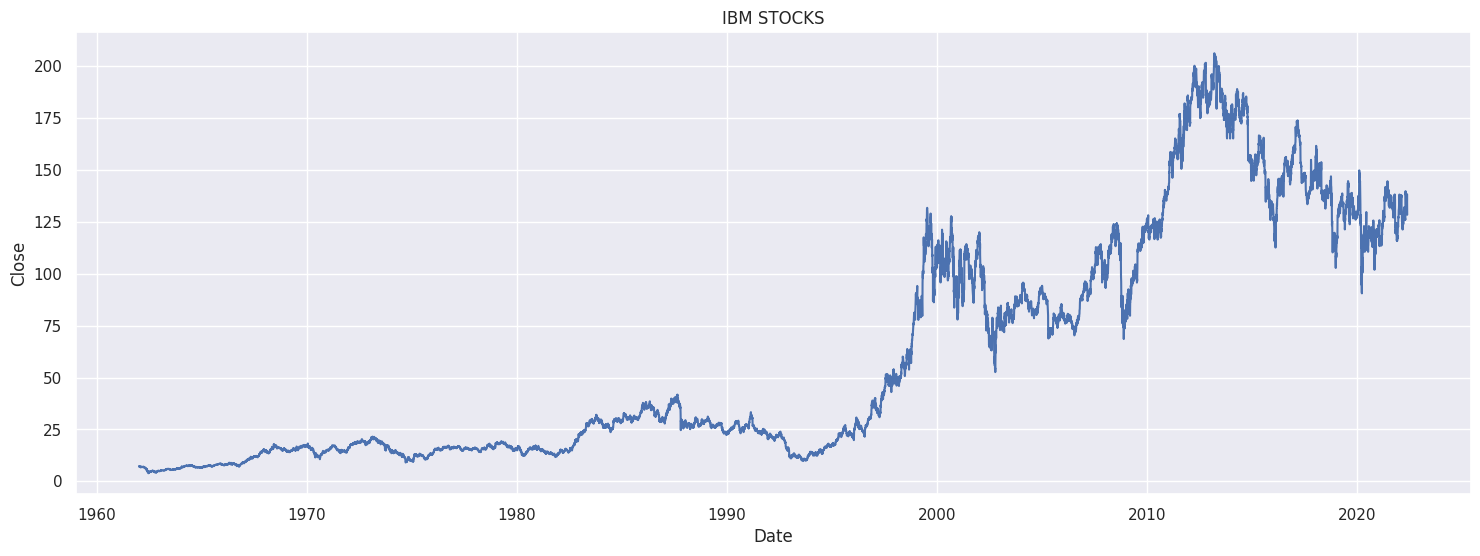

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(ibmStocks)
plt.title('IBM STOCKS')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

In [ ]:
date = stocks['Date'].values
close = stocks['Close'].values

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

# **Data Splitting**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(close, date, test_size = 0.2, shuffle = False)

In [ ]:
print('Total of Data Training:',len(x_train))
print('Total of Data Testing:',len(x_test))

Total of Data Training: 12161
Total of Data Testing: 3041


# **Normalization Data**

In [ ]:
scaler = MinMaxScaler()
train_scale = scaler.fit_transform(x_train.reshape(-1, 1))
test_scale = scaler.fit_transform(x_test.reshape(-1, 1))

In [ ]:
look_back = 20
data_training = TimeseriesGenerator(train_scale, train_scale, length=look_back, batch_size=20)
data_testing = TimeseriesGenerator(test_scale, test_scale, length=look_back, batch_size=1)

# **Build Model using LSTM**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(64, 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation=tf.keras.activations.swish),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64, 64)            16896     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30401 (237.51 KB)
Trainable params: 30401 (237.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Creating Callback**

In [ ]:
minMax = (stocks['Close'].max() - stocks['Close'].min()) * 10/100
print(minMax)

20.2409179


In [ ]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< minMax):
      self.model.stop_training = True
      print("\n MAE of the model < 10% of data scale")
callbacks = myCallback()

# **Result 1: Using SGD Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
history = model.fit(data_training ,epochs=100, validation_data=data_testing, callbacks=[callbacks], verbose=1)

Epoch 1/100
608/608 [==============================] - ETA: 0s - loss: 0.0700 - mae: 0.2628
 MAE of the model < 10% of data scale
608/608 [==============================] - 45s 68ms/step - loss: 0.0700 - mae: 0.2628 - val_loss: 0.1546 - val_mae: 0.5145


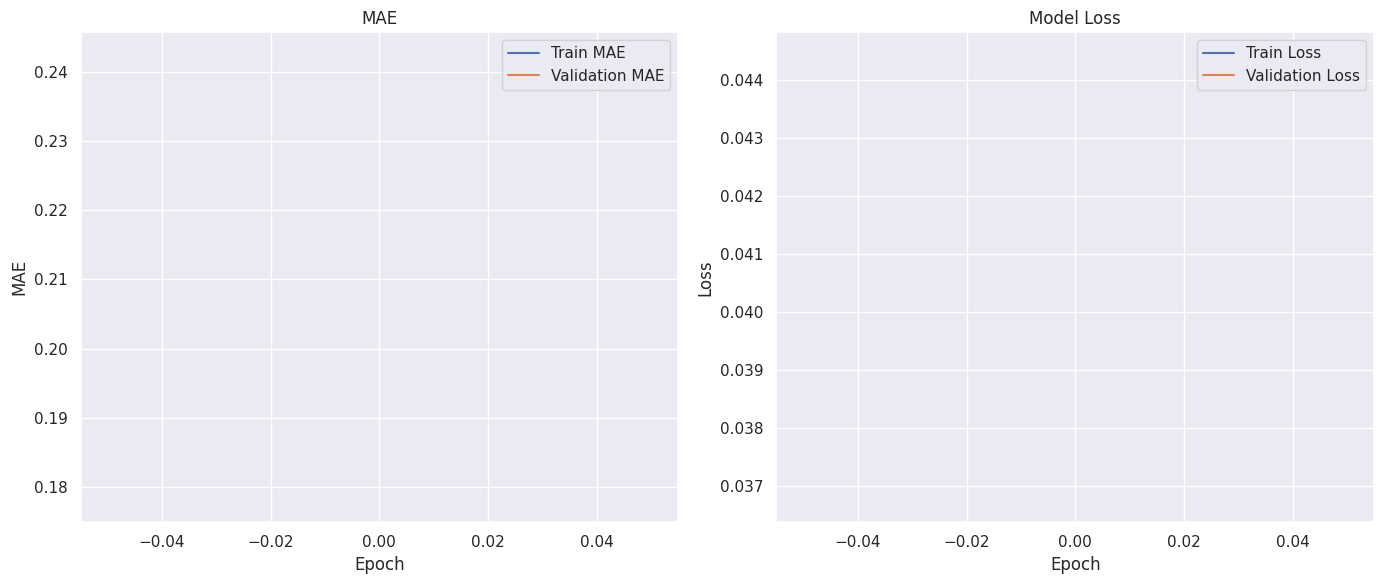

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting MAE
axes[0].plot(history.history['mae'], label='Train MAE')
axes[0].plot(history.history['val_mae'], label='Validation MAE')
axes[0].set_title('MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

# Plotting Model Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()



# **Result 2: Using Adam Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8, beta_1=0.9, beta_2=0.999)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
history = model.fit(data_training ,epochs=100, validation_data=data_testing, callbacks=[callbacks], verbose=1)

Epoch 1/100
608/608 [==============================] - ETA: 0s - loss: 3.6218e-04 - mae: 0.0221
 MAE of the model < 10% of data scale
608/608 [==============================] - 95s 144ms/step - loss: 3.6218e-04 - mae: 0.0221 - val_loss: 9.3897e-04 - val_mae: 0.0327


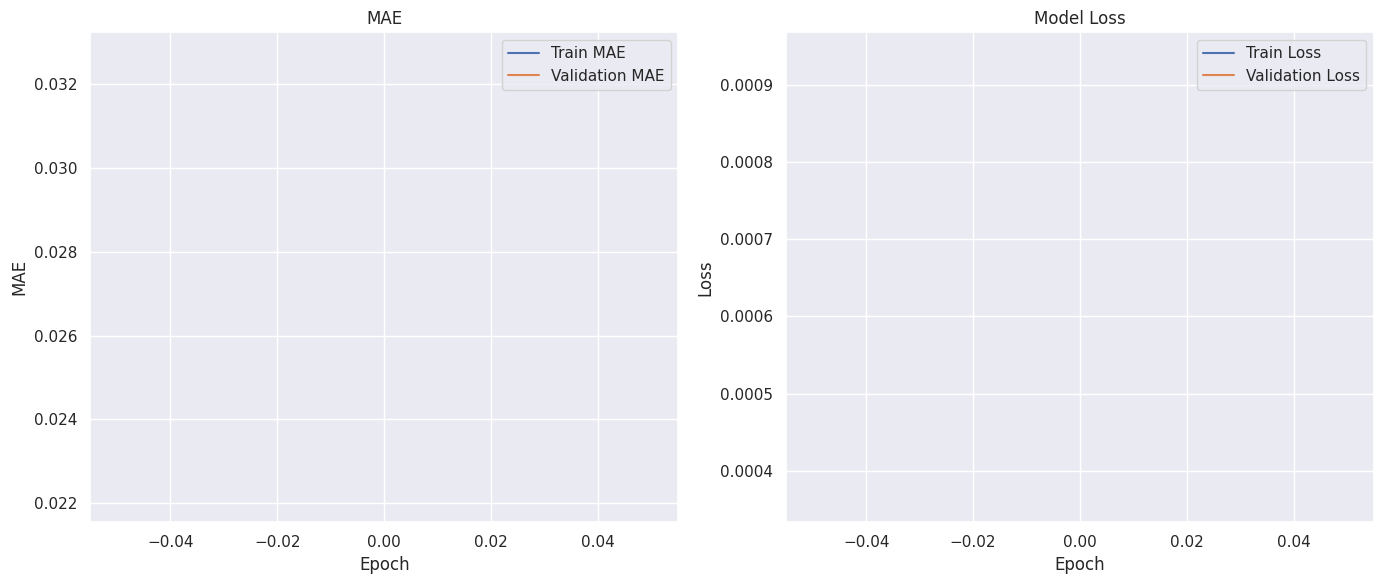

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting MAE
axes[0].plot(history.history['mae'], label='Train MAE')
axes[0].plot(history.history['val_mae'], label='Validation MAE')
axes[0].set_title('MAE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
axes[0].legend()

# Plotting Model Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

# **Evaluation Between Result 1 and 2**


---


* **Optimizers**: Result 1 uses SGD, while Result 2 uses Adam. Both optimizers seem to perform well, but Adam achieves lower training loss and MAE in less time compared to SGD.

* **Overfitting**: Result 1 shows a potential slight overfitting with a noticeable increase in validation loss and MAE. Result 2, on the other hand, demonstrates good generalization with low validation loss and MAE.

* **Training Time**: Result 2 takes longer per epoch to train, which might be a consideration depending on computational resources and time constraints.

**In summary, Result 2 using Adam optimizer appears to be more promising, as it achieves lower training and validation errors and shows better generalization. **

---


